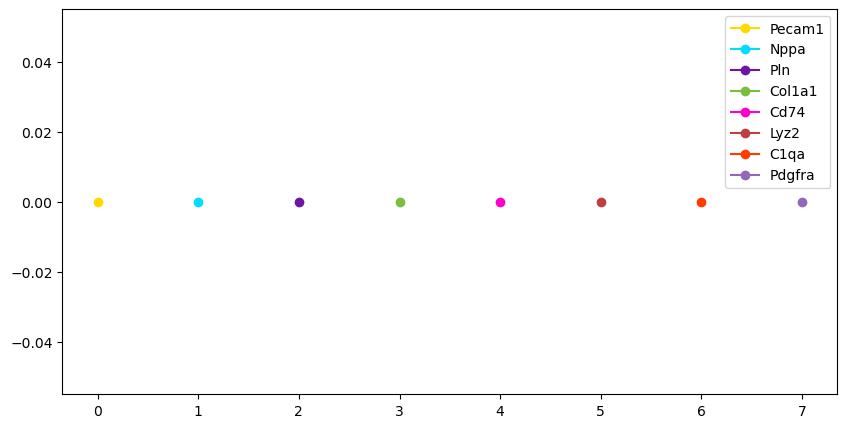

In [26]:
# just installing napari, geopandas and tifffile should be enough to import everything

import skimage.io
import pandas as pd
import napari
import geopandas as gp
from shapely.geometry import Polygon
import sys
import distinctipy
import seaborn as sns
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from skimage.segmentation import find_boundaries
import matplotlib.pyplot as plt

sys.path.append("../")
from spatialMI_functions import plot_layers_napari, crop_black_margins, add_scalebar, crop_coords

# Define color palette as tab10 from seaborn
color_palette_pts = sns.color_palette("tab10").as_hex()

# Define a list of genes of interest
# goi = {"Pecam1" : "yellow",
#        "Nppa" : "#17becf",
#        "Pln" : "#1f77b4",
#        "Col1a1" : "#2ca02c",
#        "Cd74" : "#d62728",
#        "Lyz2" : "#e377c2",
#        "C1q" : "#8c564b",
#        "Pdgfra" : "#9467bd"}

#goi = ["Pecam1","Nppa","Pln","Col1a1","Cd74","Lyz2","C1q","Pdgfra"]

# col_list = ["#d62728","#2ca02c","#e377c2","#17becf",
#             "#9467bd","#ff7f0e","#8c564b","#9467bd"]

# gene_ord = ['Cd74', 'Col1a1', 'Lyz2', 'Nppa', 'Pdgfra', 'Pecam1', 'Pln']

goi = {"Pecam1" : "#ffd900",
       #"Cdh5" : "#ffc300",
       "Nppa" : "#00ddff",
       #"Npr3" : "#ff8200",
       "Pln" : "#6e15a5",
       "Col1a1" : "#78bf3e",
       "Cd74" : "#ff00cc",
       "Lyz2" : "#bf3e3e",
       "C1qa" : "#ff3c00",
       "Pdgfra" : "#9467bd",
       #"Ryr2" : "#722974",
       #"Vim" : "#267109"
       }

# Plot the keys from goi alognside their colors
fig, ax = plt.subplots(1,1,figsize=(10,5))
for i, gene in enumerate(goi.keys()):
    ax.plot(i,0, marker="o", color=goi[gene], label=gene)
ax.legend()
plt.show()

# Plot a full image to select regions of interest

In [25]:
sample = "sample_2d_r1_s1"

## segmentation mask
mask_dir = "../../../results/nf-core_molkart/filtered_masks/"
mask = skimage.io.imread(mask_dir+sample+"_cellpose_filtered.tif")
img_dir = "../../../results/nf-core_molkart/stack/"
dapi_wga = skimage.io.imread(img_dir+sample+"_stack.ome.tif")

## Spots
spots = pd.read_csv('../../../results/nf-core_molkart/mindagap/'+sample+"_"+sample+'.spots_markedDups.txt', delimiter='\t', header=None)
# Please name the columns of spots X,Y,Z and gene
spots.columns = ['x', 'y', 'z', 'gene_target']
# Filter out gene with the name Duplicated
spots = spots[spots.gene_target != "Duplicated"]
# Subset for only genes of interest
spots = spots[spots.gene_target.isin(list(goi.keys()))]

## ROI for zoom in
#roi = pd.read_csv("../../annotations/molkart/Figure2_rois/"+sample+".roi.csv")

## Output#
outdir = "../../output/molkart/figure2_images/"

## Generate plots of spots alongside masks
gdf = gp.GeoDataFrame(
    spots, geometry=gp.points_from_xy(
        spots.x, spots.y)
        )

points_view = gdf
xmax, ymax = points_view["x"].max(), points_view["y"].max()

points_view = points_view.sort_values(by='gene_target')
points_view['cell_id'] = points_view.index

# Replace numbers in gene_target_dict with colors from distinctipy
points_props = {'cell_id': points_view['cell_id'].to_numpy(),
                # Fill the gene_target column with values for each gene stored in the dictionary
                #'gene_target': points_view['gene_target'].map(gene_target_dict).to_numpy()
                # Instead of using the value from gene_target_dict, use the key
                'gene_target': points_view['gene_target'].to_numpy()
}

## Make sure color cycle order is same as gene order
gene_order = points_view.gene_target.unique()
# Generate a list with colors based on the order of genes in gene_order
col_list = [goi[gene] for gene in gene_order]

viewer = napari.Viewer()
#boundaries = find_boundaries(mask_crop, mode='thick')
#viewer.add_labels(boundaries, visible=True, opacity = 1,color={0:'transparent', 1:(1,1,1)})
#viewer.add_image(dapi_wga, name='DAPI', colormap='blue', blending='additive', visible=True)
viewer.add_points(points_view[['y', 'x']].to_numpy(),
                  properties=points_props,
                  face_color='gene_target',
                  face_color_cycle=col_list,
                  size=4,
                  edge_width_is_relative=False,
                  edge_width= 0)

# full_screenshot = outdir+sample+".spots.zoom.wborder.png"
# viewer.screenshot(path=full_screenshot, scale=4)

# crop_screenshot = outdir+sample+".spots.zoom.clean.png"
# crop_black_margins(full_screenshot, crop_screenshot)

<Points layer 'Points' at 0x2e2e30ed0>

## Sample Control (sample_control_r2_s1)

In [27]:
sample = "sample_control_r2_s1"

## segmentation mask
mask_dir = "../../../results/nf-core_molkart/filtered_masks/"
mask = skimage.io.imread(mask_dir+sample+"_cellpose_filtered.tif")
img_dir = "../../../results/nf-core_molkart/stack/"
dapi_wga = skimage.io.imread(img_dir+sample+"_stack.ome.tif")

## Spots
spots = pd.read_csv('../../../results/nf-core_molkart/mindagap/'+sample+"_"+sample+'.spots_markedDups.txt', delimiter='\t', header=None)
# Please name the columns of spots X,Y,Z and gene
spots.columns = ['x', 'y', 'z', 'gene_target']
# Filter out gene with the name Duplicated
spots = spots[spots.gene_target != "Duplicated"]
# Subset for only genes of interest
spots = spots[spots.gene_target.isin(list(goi.keys()))]

## ROI for zoom in
roi = pd.read_csv("../../annotations/molkart/Figure2_rois/"+sample+".roi.csv")

## Output#
outdir = "../../output/molkart/figure2_images/"

bbox = roi.iloc[:, -2:].to_numpy()
mask_crop = mask[int(bbox[0, 0]):int(bbox[2, 0]), int(bbox[0, 1]): int(bbox[2, 1])]

## Generate plots of spots alongside masks
gdf = gp.GeoDataFrame(
    spots, geometry=gp.points_from_xy(
        spots.x, spots.y)
        )

polygon = Polygon(roi.iloc[:, :-3:-1].to_numpy())
poly_gpd = gp.GeoDataFrame(index=[0], geometry=[polygon])

# Basically fastest way to get all points within a polygon.
subset_points = gp.sjoin(gdf, poly_gpd, predicate='within')
points_view = crop_coords(roi, subset_points)
xmax, ymax = points_view["x"].max(), points_view["y"].max()

points_view = points_view.sort_values(by='gene_target')
points_view['cell_id'] = points_view.index

# Replace numbers in gene_target_dict with colors from distinctipy
points_props = {'cell_id': points_view['cell_id'].to_numpy(),
                # Fill the gene_target column with values for each gene stored in the dictionary
                #'gene_target': points_view['gene_target'].map(gene_target_dict).to_numpy()
                # Instead of using the value from gene_target_dict, use the key
                'gene_target': points_view['gene_target'].to_numpy()
}

## Make sure color cycle order is same as gene order
gene_order = points_view.gene_target.unique()
# Generate a list with colors based on the order of genes in gene_order
col_list = [goi[gene] for gene in gene_order]

viewer = napari.Viewer()
#boundaries = find_boundaries(mask_crop, mode='thick')
#viewer.add_labels(boundaries, visible=True, opacity = 1,color={0:'transparent', 1:(1,1,1)})
#viewer.add_image(dapi_wga, name='DAPI', colormap='blue', blending='additive', visible=True)
viewer.add_points(points_view[['y', 'x']].to_numpy(),
                  properties=points_props,
                  face_color='gene_target',
                  face_color_cycle=col_list,
                  size=4,
                  edge_width_is_relative=False,
                  edge_width= 0)

full_screenshot = outdir+sample+".spots.zoom.wborder.png"
viewer.screenshot(path=full_screenshot, scale=4)

crop_screenshot = outdir+sample+".spots.zoom.clean.png"
crop_black_margins(full_screenshot, crop_screenshot)

## Sample 2 days (sample_2d_r1_s1)

In [23]:
sample = "sample_2d_r1_s1"

## segmentation mask
mask_dir = "../../../results/nf-core_molkart/filtered_masks/"
mask = skimage.io.imread(mask_dir+sample+"_cellpose_filtered.tif")
img_dir = "../../../results/nf-core_molkart/stack/"
dapi_wga = skimage.io.imread(img_dir+sample+"_stack.ome.tif")

## Spots
spots = pd.read_csv('../../../results/nf-core_molkart/mindagap/'+sample+"_"+sample+'.spots_markedDups.txt', delimiter='\t', header=None)
# Please name the columns of spots X,Y,Z and gene
spots.columns = ['x', 'y', 'z', 'gene_target']
# Filter out gene with the name Duplicated
spots = spots[spots.gene_target != "Duplicated"]
# Subset for only genes of interest
spots = spots[spots.gene_target.isin(list(goi.keys()))]

## ROI for zoom in
roi = pd.read_csv("../../annotations/molkart/Figure2_rois/"+sample+".roi.csv")

## Output#
outdir = "../../output/molkart/figure2_images/"

bbox = roi.iloc[:, -2:].to_numpy()
mask_crop = mask[int(bbox[0, 0]):int(bbox[2, 0]), int(bbox[0, 1]): int(bbox[2, 1])]

## Generate plots of spots alongside masks
gdf = gp.GeoDataFrame(
    spots, geometry=gp.points_from_xy(
        spots.x, spots.y)
        )

polygon = Polygon(roi.iloc[:, :-3:-1].to_numpy())
poly_gpd = gp.GeoDataFrame(index=[0], geometry=[polygon])

# Basically fastest way to get all points within a polygon.
subset_points = gp.sjoin(gdf, poly_gpd, predicate='within')
points_view = crop_coords(roi, subset_points)
xmax, ymax = points_view["x"].max(), points_view["y"].max()

points_view = points_view.sort_values(by='gene_target')
points_view['cell_id'] = points_view.index

# Replace numbers in gene_target_dict with colors from distinctipy
points_props = {'cell_id': points_view['cell_id'].to_numpy(),
                # Fill the gene_target column with values for each gene stored in the dictionary
                #'gene_target': points_view['gene_target'].map(gene_target_dict).to_numpy()
                # Instead of using the value from gene_target_dict, use the key
                'gene_target': points_view['gene_target'].to_numpy()
}

## Make sure color cycle order is same as gene order
gene_order = points_view.gene_target.unique()
# Generate a list with colors based on the order of genes in gene_order
col_list = [goi[gene] for gene in gene_order]

viewer = napari.Viewer()
#boundaries = find_boundaries(mask_crop, mode='thick')
#viewer.add_labels(boundaries, visible=True, opacity = 1,color={0:'transparent', 1:(1,1,1)})
#viewer.add_image(dapi_wga, name='DAPI', colormap='blue', blending='additive', visible=True)
viewer.add_points(points_view[['y', 'x']].to_numpy(),
                  properties=points_props,
                  face_color='gene_target',
                  face_color_cycle=col_list,
                  size=4,
                  edge_width_is_relative=False,
                  edge_width= 0)

full_screenshot = outdir+sample+".spots.zoom.wborder.png"
viewer.screenshot(path=full_screenshot, scale=4)

crop_screenshot = outdir+sample+".spots.zoom.clean.png"
crop_black_margins(full_screenshot, crop_screenshot)

## Sample 4 days (sample_4d_r2_s1)

In [20]:
sample = "sample_4d_r2_s1"

## segmentation mask
mask_dir = "../../../results/nf-core_molkart/filtered_masks/"
mask = skimage.io.imread(mask_dir+sample+"_cellpose_filtered.tif")
img_dir = "../../../results/nf-core_molkart/stack/"
dapi_wga = skimage.io.imread(img_dir+sample+"_stack.ome.tif")

## Spots
spots = pd.read_csv('../../../results/nf-core_molkart/mindagap/'+sample+"_"+sample+'.spots_markedDups.txt', delimiter='\t', header=None)
# Please name the columns of spots X,Y,Z and gene
spots.columns = ['x', 'y', 'z', 'gene_target']
# Filter out gene with the name Duplicated
spots = spots[spots.gene_target != "Duplicated"]
# Subset for only genes of interest
spots = spots[spots.gene_target.isin(list(goi.keys()))]

## ROI for zoom in
roi = pd.read_csv("../../annotations/molkart/Figure2_rois/"+sample+".roi.csv")

## Output#
outdir = "../../output/molkart/figure2_images/"

bbox = roi.iloc[:, -2:].to_numpy()
mask_crop = mask[int(bbox[0, 0]):int(bbox[2, 0]), int(bbox[0, 1]): int(bbox[2, 1])]

## Generate plots of spots alongside masks
gdf = gp.GeoDataFrame(
    spots, geometry=gp.points_from_xy(
        spots.x, spots.y)
        )

polygon = Polygon(roi.iloc[:, :-3:-1].to_numpy())
poly_gpd = gp.GeoDataFrame(index=[0], geometry=[polygon])

# Basically fastest way to get all points within a polygon.
subset_points = gp.sjoin(gdf, poly_gpd, predicate='within')
points_view = crop_coords(roi, subset_points)
xmax, ymax = points_view["x"].max(), points_view["y"].max()

points_view = points_view.sort_values(by='gene_target')
points_view['cell_id'] = points_view.index

# Replace numbers in gene_target_dict with colors from distinctipy
points_props = {'cell_id': points_view['cell_id'].to_numpy(),
                # Fill the gene_target column with values for each gene stored in the dictionary
                #'gene_target': points_view['gene_target'].map(gene_target_dict).to_numpy()
                # Instead of using the value from gene_target_dict, use the key
                'gene_target': points_view['gene_target'].to_numpy()
}

## Make sure color cycle order is same as gene order
gene_order = points_view.gene_target.unique()
# Generate a list with colors based on the order of genes in gene_order
col_list = [goi[gene] for gene in gene_order]

viewer = napari.Viewer()
#boundaries = find_boundaries(mask_crop, mode='thick')
#viewer.add_labels(boundaries, visible=True, opacity = 1,color={0:'transparent', 1:(1,1,1)})
#viewer.add_image(dapi_wga, name='DAPI', colormap='blue', blending='additive', visible=True)
viewer.add_points(points_view[['y', 'x']].to_numpy(),
                  properties=points_props,
                  face_color='gene_target',
                  face_color_cycle=col_list,
                  size=4,
                  edge_width_is_relative=False,
                  edge_width= 0)

full_screenshot = outdir+sample+".spots.zoom.wborder.png"
viewer.screenshot(path=full_screenshot, scale=4)

crop_screenshot = outdir+sample+".spots.zoom.clean.png"
crop_black_margins(full_screenshot, crop_screenshot)